In [270]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import sys
sys.path.append("../../scripts")
import importlib

import model
importlib.reload(model)
from model import Model, model_from_file

import model_plot
importlib.reload(model_plot)
from model_plot import model_plot

import norms
importlib.reload(norms)
from norms import *

%matplotlib inline

In [271]:
models_dir = '../../bin/'

In [272]:
model = model_from_file(models_dir + 'model.csv')

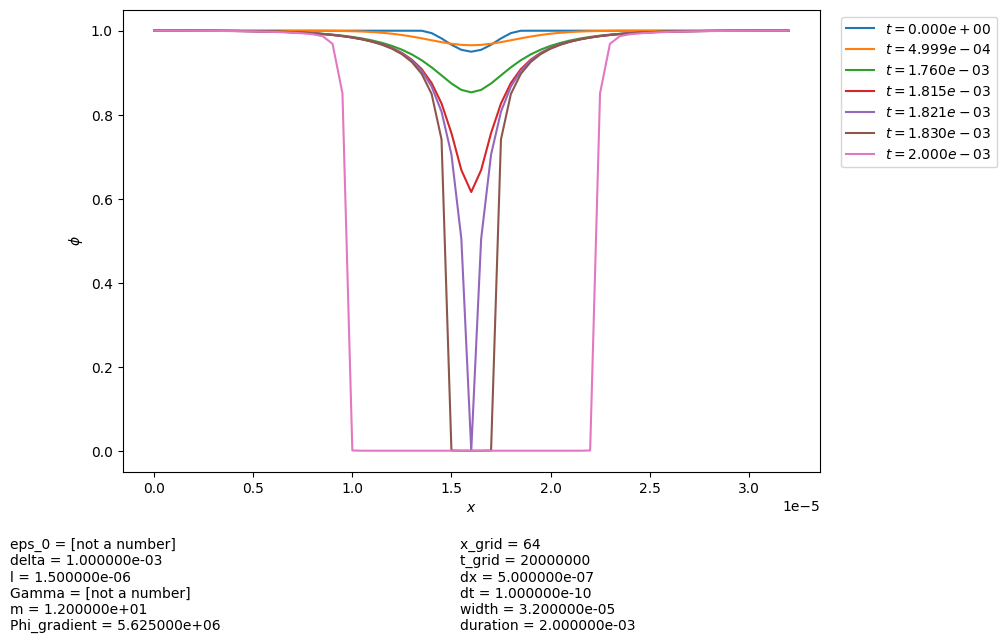

In [273]:
ts = [0, 5e-4, 1.76e-3, 1.815e-3, 1.821e-3, 1.83e-3, 2e-3]
model_plot(model, ts, figsize=(9, 6))

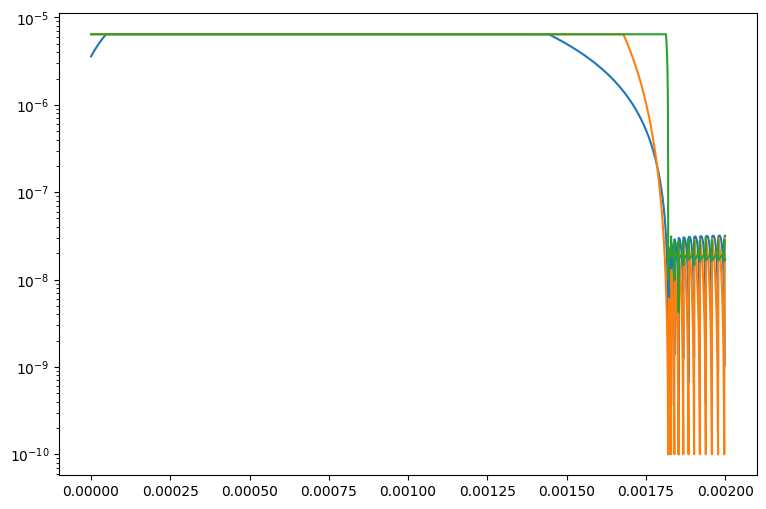

In [274]:
plt.figure(figsize=(9, 6))
plt.yscale('log')
plt.plot(model.ts, model._dt_adaptive_phi)
plt.plot(model.ts[1:], model._dt_adaptive_energy[1:])
plt.plot(model.ts, model._dt_adaptive_stability)
plt.show()

In [275]:
model_ad_phi = model_from_file(models_dir + 'model_ad_phi.csv')

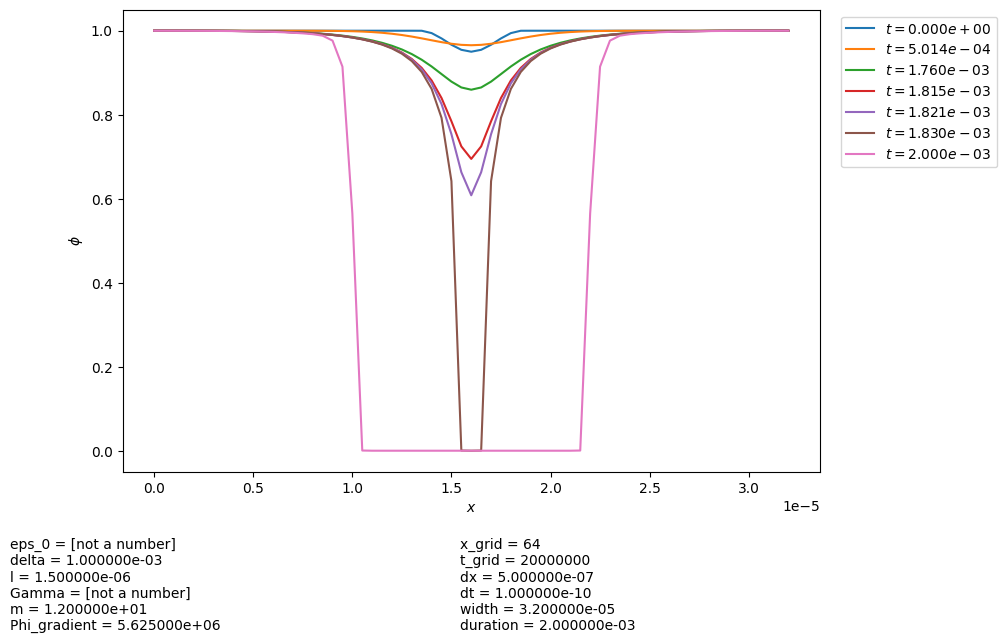

In [276]:
model_plot(model_ad_phi, ts, figsize=(9, 6))

In [277]:
model_ad_energy = model_from_file(models_dir + 'model_ad_energy.csv')

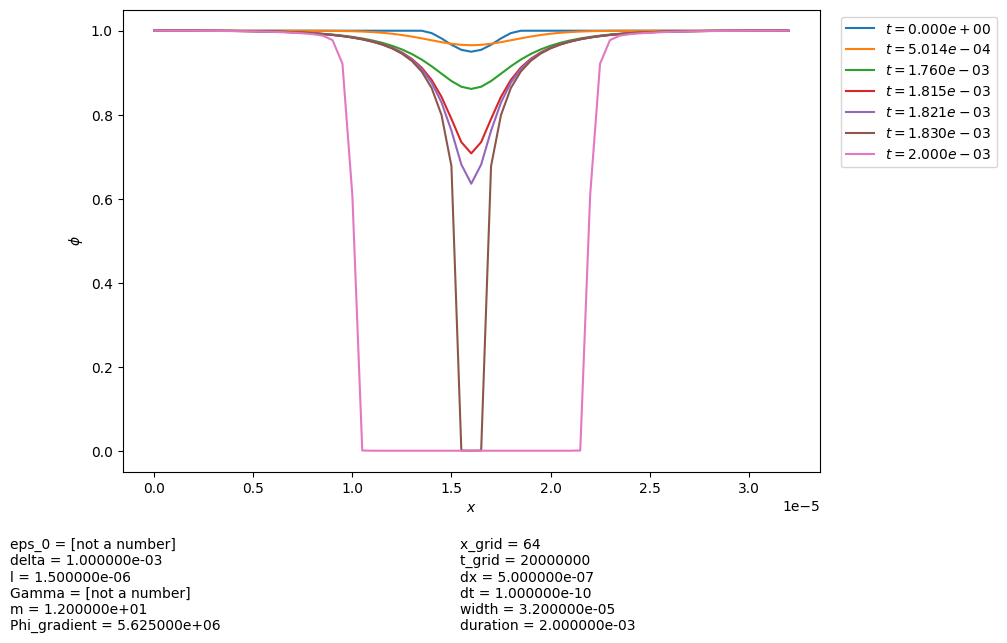

In [278]:
model_plot(model_ad_energy, ts, figsize=(9, 6))

In [279]:
model_ad_stability = model_from_file(models_dir + 'model_ad_stability.csv')

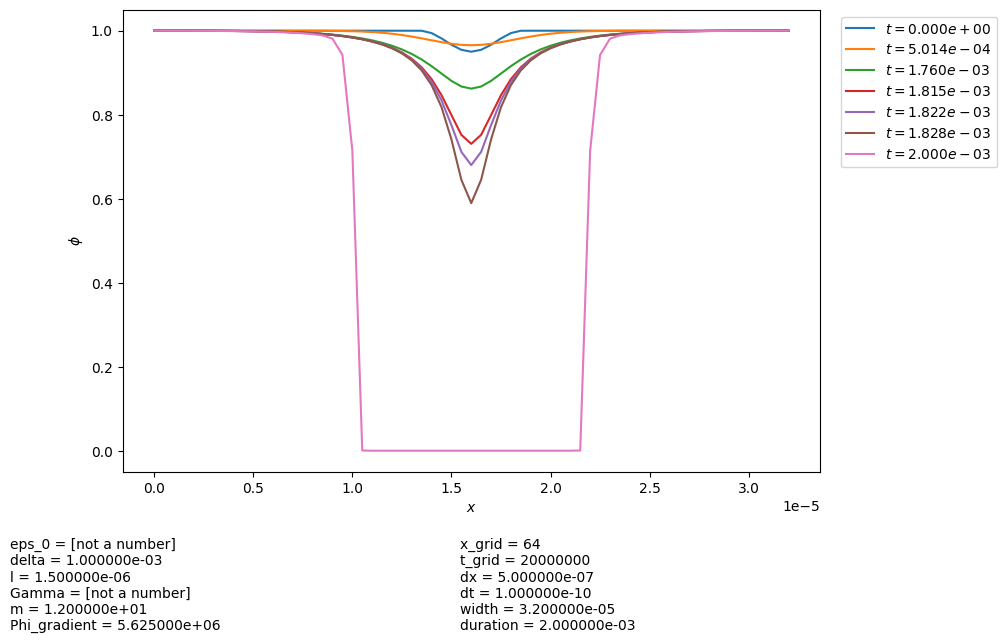

In [280]:
model_plot(model_ad_stability, ts, figsize=(9, 6))

In [281]:
def boost(model_adaptive):
    print('Шагов было:', model._t_iterations.sum())
    print('Шагов стало:', model_adaptive._t_iterations.sum() - 1)
    print('Ускорение ~', model._t_iterations.sum() / (model_adaptive._t_iterations.sum() - 1))

In [282]:
boost(model_ad_phi)

Шагов было: 19998721
Шагов стало: 24992
Ускорение ~ 800.2049055697823


In [283]:
boost(model_ad_energy)

Шагов было: 19998721
Шагов стало: 186909
Ускорение ~ 106.99710019314212


In [284]:
boost(model_ad_stability)

Шагов было: 19998721
Шагов стало: 13562
Ускорение ~ 1474.6144373986137


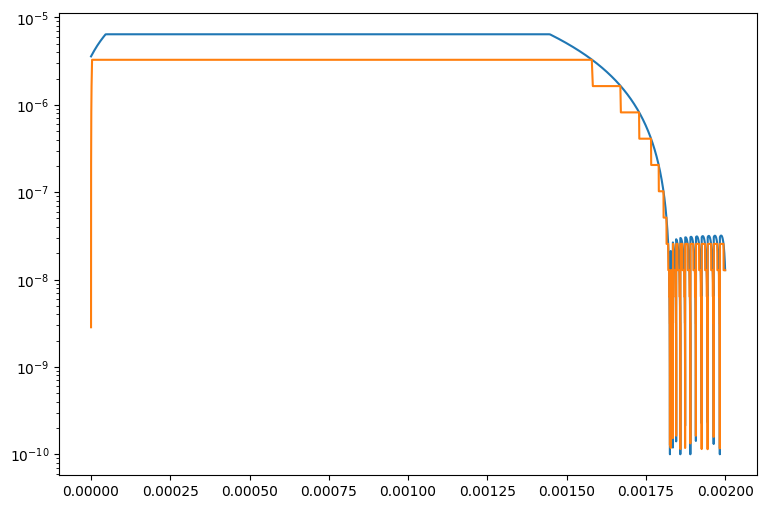

In [285]:
plt.figure(figsize=(9, 6))
plt.yscale('log')
plt.plot(model_ad_phi.ts, model_ad_phi._dt_adaptive_phi)
plt.plot(model_ad_phi.ts[:-1], (model_ad_phi.ts[1:] - model_ad_phi.ts[:-1]) / model_ad_phi._t_iterations[1:])
plt.show()

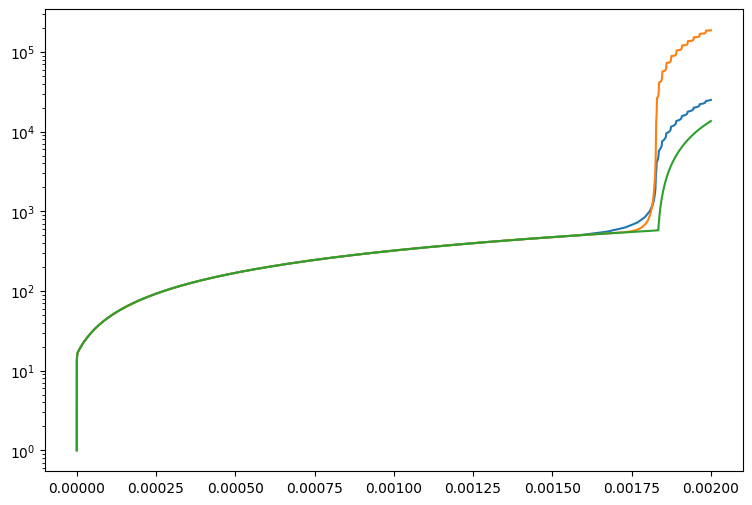

In [286]:
plt.figure(figsize=(9, 6))
plt.yscale('log')
plt.plot(model_ad_phi.ts, model_ad_phi._t_iterations.cumsum())
plt.plot(model_ad_energy.ts, model_ad_energy._t_iterations.cumsum())
plt.plot(model_ad_stability.ts, model_ad_stability._t_iterations.cumsum())
plt.show()

## Сравнения по норме

In [287]:
diff_ad_phi, ts_ad_phi_ = phi_difference(model, model_ad_phi)
diff_ad_energy, ts_ad_energy_ = phi_difference(model, model_ad_energy)
diff_ad_stability, ts_ad_stability_ = phi_difference(model, model_ad_stability)

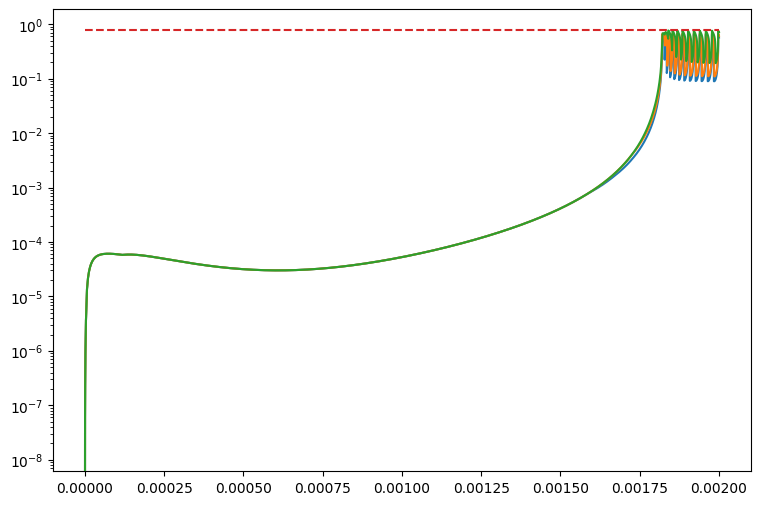

In [288]:
plt.figure(figsize=(9, 6))
plt.yscale('log')
plt.plot(ts_ad_phi_, np.abs(diff_ad_phi).max(axis = 1))
plt.plot(ts_ad_energy_, np.abs(diff_ad_energy).max(axis = 1))
plt.plot(ts_ad_stability_, np.abs(diff_ad_stability).max(axis = 1))
plt.plot([0, 2e-3], [norm_uniform(diff_ad_stability), norm_uniform(diff_ad_stability)], '--')
plt.show()

Рост отклонения близок к экспоненциальному. Это в духе неустойчивого равновесия.

In [289]:
metric_ad_phi, t_shift_ad_phi = \
    metric_shifted(model_ad_phi.df_phi, model_ad_phi.ts, model.df_phi, model.ts)

In [290]:
metric_ad_energy, t_shift_ad_energy = \
    metric_shifted(model_ad_energy.df_phi, model_ad_energy.ts, model.df_phi, model.ts)

In [291]:
metric_ad_stability, t_shift_ad_stability = \
    metric_shifted(model_ad_stability.df_phi, model_ad_stability.ts, model.df_phi, model.ts,)

In [292]:
def window_min(values, k):
    if k == 0:
        return values
    return np.array([values[i - k:i + k].min() for i in range(k, len(values) - k)])

def window_max(values, k):
    if k == 0:
        return values
    return np.array([values[i - k:i + k].max() for i in range(k, len(values) - k)])

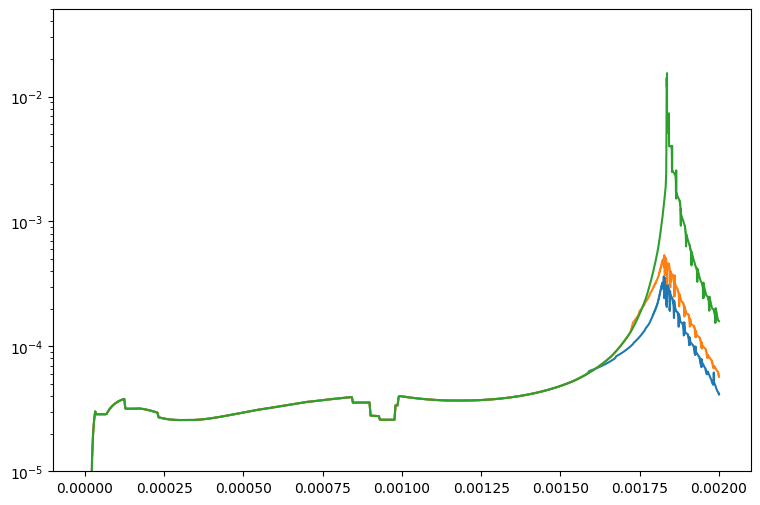

In [293]:
plt.figure(figsize=(9, 6))
plt.ylim([1e-5, 5e-2])
plt.yscale('log')
k = 5
plt.plot(model_ad_phi.ts[k:-k], window_min(metric_ad_phi, k))
plt.plot(model_ad_energy.ts[k:-k], window_min(metric_ad_energy, k))
plt.plot(model_ad_stability.ts[k:-k], window_min(metric_ad_stability, k))
plt.show()

Формально запаздывание отрицательно, но это из-за перестановки моделей в функции. Модели с адаптацией отстают по времени.

In [294]:
k = 5
print(window_min(metric_ad_phi, k).max())
print(window_min(metric_ad_energy, k).max())
print(window_min(metric_ad_stability, k).max())

0.0003636622691679525
0.0005376114413038202
0.01540621748205484


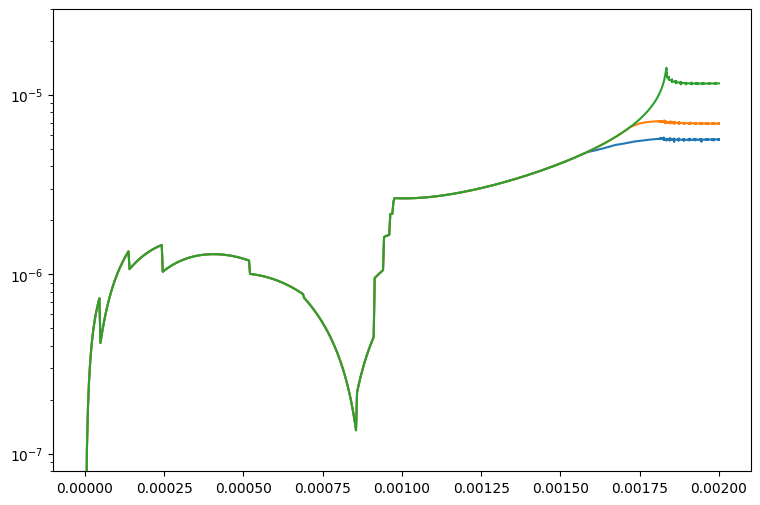

In [304]:
plt.figure(figsize=(9, 6))
plt.ylim([8e-8, 3e-5])
plt.yscale('log')
plt.plot(model_ad_phi.ts, np.abs(t_shift_ad_phi))
plt.plot(model_ad_energy.ts, np.abs(t_shift_ad_energy))
plt.plot(model_ad_stability.ts, np.abs(t_shift_ad_stability))
plt.show()

In [305]:
print(np.abs(t_shift_ad_phi).max())
print(np.abs(t_shift_ad_energy).max())
print(np.abs(t_shift_ad_stability).max())

5.794909221600836e-06
7.2115298069464384e-06
1.4166641142901932e-05


## Увеличение точности

In [306]:
model_ad_phi_tol = model_from_file(models_dir + 'model_ad_phi_tol.csv')

In [307]:
metric_ad_phi_tol, t_shift_ad_phi_tol = \
    metric_shifted(model_ad_phi_tol.df_phi, model_ad_phi_tol.ts, model.df_phi, model.ts)

In [308]:
model_ad_phi_max = model_from_file(models_dir + 'model_ad_phi_max.csv')

In [309]:
metric_ad_phi_max, t_shift_ad_phi_max = \
    metric_shifted(model_ad_phi_max.df_phi, model_ad_phi_max.ts, model.df_phi, model.ts)

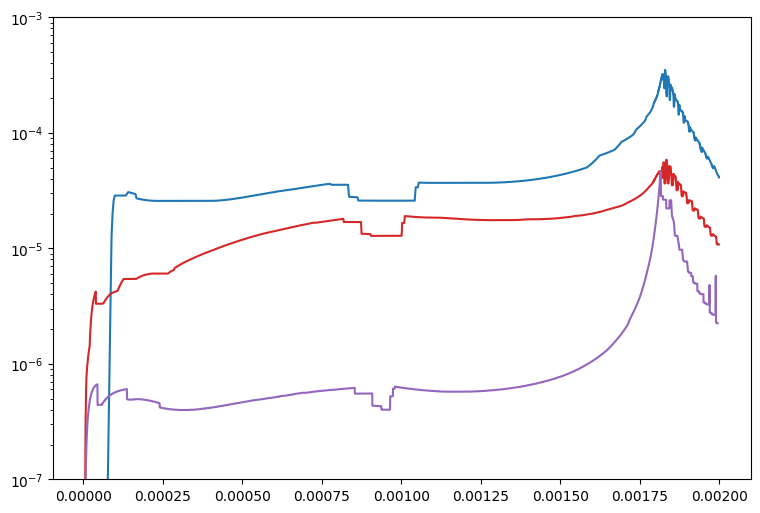

In [313]:
plt.figure(figsize=(9, 6))
plt.ylim([1e-7, 1e-3])
plt.yscale('log')
k = 25
plt.plot(model_ad_phi.ts[k:-k], window_min(metric_ad_phi, k), color='C0')
plt.plot(model_ad_phi_tol.ts[k:-k], window_min(metric_ad_phi_tol, k), color='C3')
plt.plot(model_ad_phi_max.ts[k:-k], window_min(metric_ad_phi_max, k), color='C4')
plt.show()

In [314]:
k = 25
print(window_min(metric_ad_phi, k).max())
print(window_min(metric_ad_phi_tol, k).max())
print(window_min(metric_ad_phi_max, k).max())

0.0003503993444414766
5.845961804995525e-05
4.61668174155383e-05


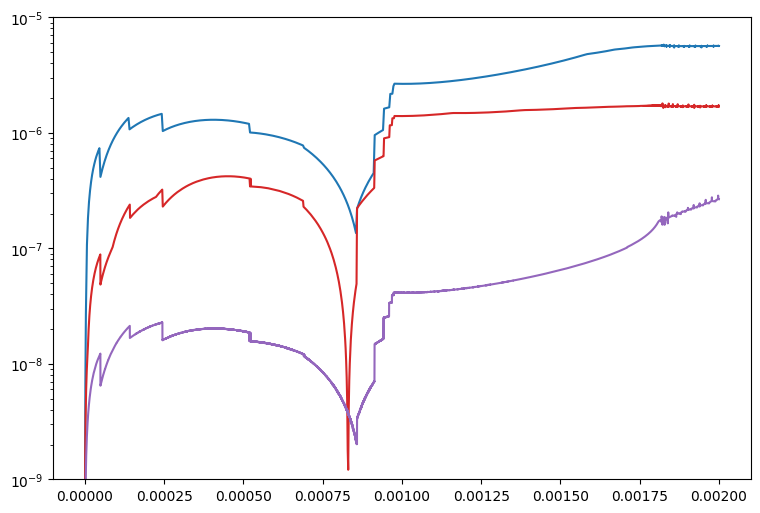

In [315]:
plt.figure(figsize=(9, 6))
plt.ylim([1e-9, 1e-5])
plt.yscale('log')
plt.plot(model_ad_phi.ts, np.abs(t_shift_ad_phi), color='C0')
plt.plot(model_ad_phi_tol.ts, np.abs(t_shift_ad_phi_tol), color='C3')
plt.plot(model_ad_phi_max.ts, np.abs(t_shift_ad_phi_max), color='C4')
plt.show()

In [316]:
print(np.abs(t_shift_ad_phi).max())
print(np.abs(t_shift_ad_phi_tol).max())
print(np.abs(t_shift_ad_phi_max).max())

5.794909221600836e-06
1.7969165126948104e-06
2.8567205581750075e-07


In [317]:
model_ad_energy_tol = model_from_file(models_dir + 'model_ad_energy_tol.csv')

In [318]:
metric_ad_energy_tol, t_shift_ad_energy_tol = \
    metric_shifted(model_ad_energy_tol.df_phi, model_ad_energy_tol.ts, model.df_phi, model.ts)

In [319]:
model_ad_energy_max = model_from_file(models_dir + 'model_ad_energy_max.csv')

In [320]:
metric_ad_energy_max, t_shift_ad_energy_max = \
    metric_shifted(model_ad_energy_max.df_phi, model_ad_energy_max.ts, model.df_phi, model.ts)

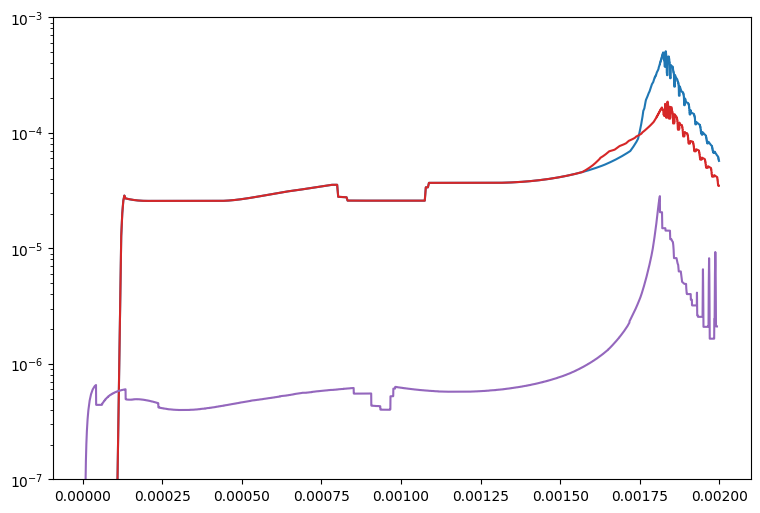

In [323]:
plt.figure(figsize=(9, 6))
plt.ylim([1e-7, 1e-3])
plt.yscale('log')
k = 35
plt.plot(model_ad_energy.ts[k:-k], window_min(metric_ad_energy, k), color='C0')
plt.plot(model_ad_energy_tol.ts[k:-k], window_min(metric_ad_energy_tol, k), color='C3')
plt.plot(model_ad_energy_max.ts[k:-k], window_min(metric_ad_energy_max, k), color='C4')
plt.show()

In [339]:
k = 35
print(window_min(metric_ad_energy, k).max())
print(window_min(metric_ad_energy_tol, k).max())
print(window_min(metric_ad_energy_max, k).max())

0.0005077186910473763
0.00018604325560178658
2.8275745256656215e-05


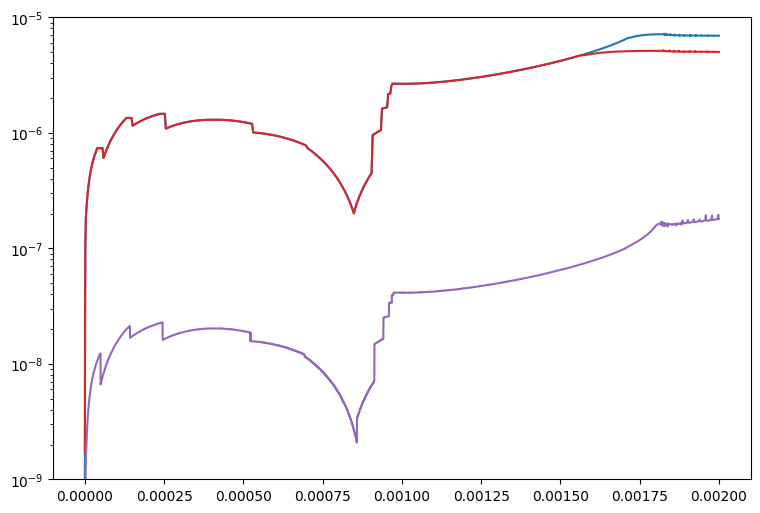

In [325]:
plt.figure(figsize=(9, 6))
plt.ylim([1e-9, 1e-5])
plt.yscale('log')
k = 3
plt.plot(model_ad_energy.ts[k:-k], window_max(np.abs(t_shift_ad_energy), k), color='C0')
plt.plot(model_ad_energy_tol.ts[k:-k], window_max(np.abs(t_shift_ad_energy_tol), k), color='C3')
plt.plot(model_ad_energy_max.ts[k:-k], window_max(np.abs(t_shift_ad_energy_max), k), color='C4')
plt.show()

In [327]:
print(np.abs(t_shift_ad_energy).max())
print(np.abs(t_shift_ad_energy_tol).max())
print(np.abs(t_shift_ad_energy_max).max())

7.2115298069464384e-06
5.195808186213763e-06
1.9472861285884513e-07


In [328]:
model_ad_stability_tol = model_from_file(models_dir + 'model_ad_stability_tol.csv')

In [329]:
metric_ad_stability_tol, t_shift_ad_stability_tol = \
    metric_shifted(model_ad_stability_tol.df_phi, model_ad_stability_tol.ts, model.df_phi, model.ts)

In [330]:
model_ad_stability_max = model_from_file(models_dir + 'model_ad_stability_max.csv')

In [331]:
metric_ad_stability_max, t_shift_ad_stability_max = \
    metric_shifted(model_ad_stability_max.df_phi, model_ad_stability_max.ts, model.df_phi, model.ts)

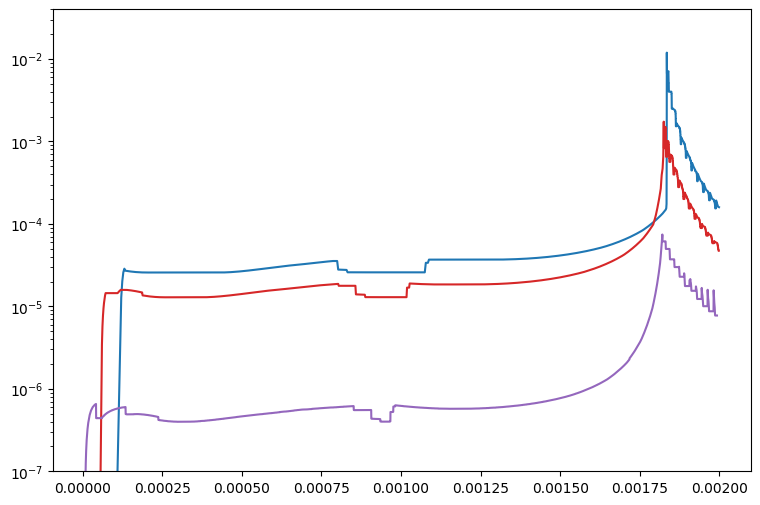

In [342]:
plt.figure(figsize=(9, 6))
plt.ylim([1e-7, 4e-2])
plt.yscale('log')
k = 35
plt.plot(model_ad_stability.ts[k:-k], window_min(metric_ad_stability, k), color='C0')
plt.plot(model_ad_stability_tol.ts[k:-k], window_min(metric_ad_stability_tol, k), color='C3')
plt.plot(model_ad_stability_max.ts[k:-k], window_min(metric_ad_stability_max, k), color='C4')
plt.show()

In [343]:
k = 35
print(window_min(metric_ad_stability, k).max())
print(window_min(metric_ad_stability_tol, k).max())
print(window_min(metric_ad_stability_max, k).max())

0.011914907444058986
0.001734247348218254
7.429405304582026e-05


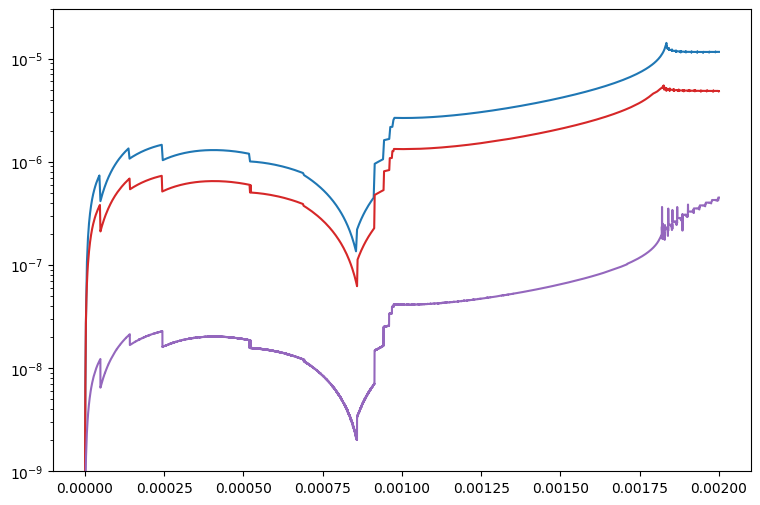

In [348]:
plt.figure(figsize=(9, 6))
plt.ylim([1e-9, 3e-5])
plt.yscale('log')
plt.plot(model_ad_stability.ts, np.abs(t_shift_ad_stability), color='C0')
plt.plot(model_ad_stability_tol.ts, np.abs(t_shift_ad_stability_tol), color='C3')
plt.plot(model_ad_stability_max.ts, np.abs(t_shift_ad_stability_max), color='C4')
plt.show()

In [349]:
print(np.abs(t_shift_ad_energy).max())
print(np.abs(t_shift_ad_energy_tol).max())
print(np.abs(t_shift_ad_energy_max).max())

7.2115298069464384e-06
5.195808186213763e-06
1.9472861285884513e-07
